**FINDING MINEFIELD PATH WITH Q-LEARNING**

In [49]:
import numpy as np
import seaborn as sns
import pandas as pd
from matplotlib import pyplot as plt

The purpose of this study is to find a path from a predefined base state to some reward state where passing through certain states in between lead to penalty. Set states are two dimensional 10 grids in X-axis and 5 grid in Y-axis. The purpose is to obtain a policy such that the agent will travel from the first state to the last by finding the shortest path and without passing through the forbidden states which are called minefields. This will be achieved through by giving the final state a positive value and penalizing minefield states.

* The agent will be treated as a class so that multiple agents can be created easily in case of a use of a grid search
* The user can experiment with different learning rates $\alpha$ although the problem is straightforward.
* $\lambda$ should be set to some value smaller than $1$ so that the policy is formed in regards to shortest path
* $\epsilon$ was set to $0.1$ as exploration is not neccessary
* I only ran $10000$ which yielded to the optimal solution but one can track reward and number of episodes to see if the reward is converging

In [110]:
class agent():

  def __init__(self,reward_matrix,start=(0,0),end=(-1,-1),epsilon=0.1,lambd=0.9,alpha=0.1):

    self.start = start
    self.end = end
    self.current = self.start
    self.epsilon = epsilon
    self.lambd=lambd
    self.alpha=alpha
    self.reward_matrix = reward_matrix
    self.length = reward_matrix.shape[0]
    self.width = reward_matrix.shape[1]
    self.qmatrix = np.zeros(shape=[4,self.length,self.width])
    self.dir_dict = {0:"up",1:"down",2:"right",3:"left"}

  def get_current(self):
    return (self.current[0],self.current[1])

  def get_end(self):
    return (self.end[0],self.end[1])

  def get_start(self):
    return (self.start[0],self.start[1])

  def set_current(self,current):
    self.current = current

  def navigate(self,action):

    current_x = self.get_current()[0]
    current_y = self.get_current()[1]

    if action == "up":
      current_y += 1
    elif action == "down":
      current_y -= 1
    elif action == "right":
      current_x += 1
    elif action == "left":
      current_x -= 1

    self.current = (current_x,current_y)

  def get_available_directions(self):

    directions = list()
    current_x = self.get_current()[0]
    current_y = self.get_current()[1]

    if current_y != self.length - 1:
      directions.append(0)

    if current_y != 0:
      directions.append(1)

    if current_x != self.width - 1:
      directions.append(2)

    if current_x != 0:
      directions.append(3)

    return directions

  def update_qmatrix(self,alpha,lambd,old_x,old_y,action):

    current_x = self.get_current()[0]
    current_y = self.get_current()[1]
    choice_list = self.get_available_directions()
    old_qvalue = self.qmatrix[action,old_y,old_x]
    max_next_qvalue = max(self.qmatrix[choice_list,current_y,current_x])
    old_reward = self.reward_matrix[current_y,current_x]
    self.qmatrix[action,old_y,old_x] = old_qvalue + alpha*(old_reward + lambd*max_next_qvalue-old_qvalue)

    return old_reward


  def epsilon_greedy(self):

    rf_eps = np.random.uniform(0,1)
    choice_list = self.get_available_directions()
    current_x = self.get_current()[0]
    current_y = self.get_current()[1]
    nav_dict = self.dir_dict

    if rf_eps > self.epsilon:

      sel_it = np.argmax(self.qmatrix[choice_list,current_y,current_x])
      sel_it = choice_list[sel_it]
      self.navigate(nav_dict[sel_it])

    else:

      sel_it = np.random.choice(choice_list)
      self.navigate(nav_dict[sel_it])

    reward = self.update_qmatrix(alpha=self.alpha,lambd=self.lambd,old_x=current_x,old_y=current_y,action=sel_it)

    return reward

  def run_episode(self):

    self.set_current(self.start)
    cum_reward = 0
    current_coord = self.get_current()
    end_coord = self.get_end()
    while current_coord != end_coord:
      reward = agent_obj.epsilon_greedy()
      current_coord = agent_obj.get_current()
      cum_reward += reward

    return cum_reward

  def get_policy_matrix(self):
    qs_image = np.zeros(shape=[agent_obj.length,agent_obj.width])
    agent_obj.set_current(agent_obj.start)
    while agent_obj.get_current() != agent_obj.get_end():
      action_ind = np.argmax(agent_obj.qmatrix[:,agent_obj.get_current()[1],agent_obj.get_current()[0]])
      action = agent_obj.dir_dict[action_ind]
      qs_image[-1*(agent_obj.get_current()[1]+1),agent_obj.get_current()[0]] = agent_obj.qmatrix[action_ind,agent_obj.get_current()[1],agent_obj.get_current()[0]]
      agent_obj.navigate(action)

    return qs_image

  def show_reward_matrix(self):
    showm = np.where(self.reward_matrix == np.min(self.reward_matrix),0,0.5)
    showm[-1,-1] = 1
    showm = pd.DataFrame(showm).iloc[::-1,:].reset_index().drop(['index'],axis=1)
    return showm



In [130]:
np.random.seed(14)
rew_dims = [5,10]
mine_pct = 0.3
reward_matrix = np.where(np.random.uniform(0,1,np.product(rew_dims)) < mine_pct,-100,0).reshape(rew_dims)
reward_matrix[rew_dims[0]-1,rew_dims[1]-1] = 1000
reward_matrix

array([[   0,    0,    0, -100,    0,    0,    0,    0,    0, -100],
       [   0,    0,    0, -100,    0, -100,    0,    0,    0,    0],
       [   0, -100,    0,    0,    0, -100,    0,    0, -100,    0],
       [   0, -100,    0, -100,    0,    0,    0,    0,    0, -100],
       [   0,    0,    0, -100,    0,    0, -100,    0,    0, 1000]])

In [146]:
agent_obj = agent(reward_matrix,epsilon=0.1,end=(reward_matrix.shape[1]-1,reward_matrix.shape[0]-1))
for i in range(10000):
  agent_obj.run_episode()
rm_show = agent_obj.show_reward_matrix()
q_show = np.where(agent_obj.get_policy_matrix() > 0,0.5,0)
q_show[0,-1] = 1
q_show = pd.DataFrame(q_show).reset_index().drop(['index'],axis=1)
q_label = np.select([rm_show == 0.5,rm_show == 0,rm_show == 1],[0,-100,1000])
q_label = pd.DataFrame(q_label).reset_index().drop(['index'],axis=1)

As one can realize, the starting state is $(4,0)$ and the purpose is to finish at $(0,9)$. The black states are minefields which yield to $-100$ reward so they are supposedly to be bypassed. As the policy graph illustrates, the minefields are bypassed and the reward was reached in a shortest path manner.

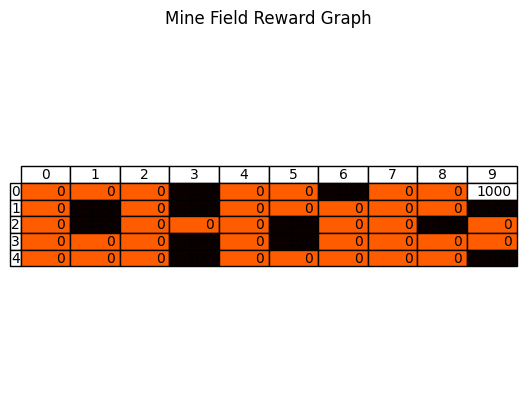

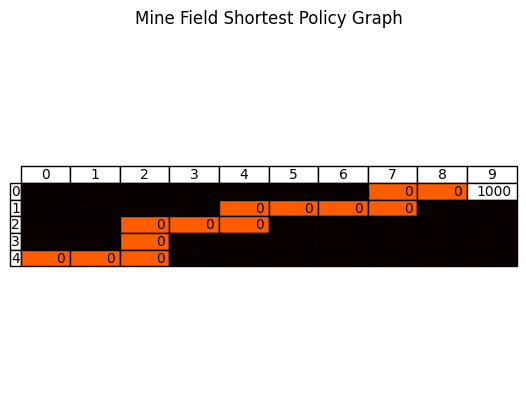

In [147]:
plt.axis('Off')
plt.title("Mine Field Reward Graph")
plt.table(cellText=np.array(q_label), rowLabels=range(rm_show.shape[0]), colLabels=range(rm_show.shape[1]), loc='center',cellColours=plt.cm.hot(np.array(rm_show)))
plt.show()
plt.axis('Off')
plt.title("Mine Field Shortest Policy Graph")
plt.table(cellText=np.array(q_label), rowLabels=range(q_show.shape[0]), colLabels=range(q_show.shape[1]), loc='center',cellColours=plt.cm.hot(np.array(q_show)))
plt.show()